Assignment 10 Supplementary: Semantic Search Demo
===============

This Python notebook guides you through the code for Text-to-Image and Image-to-Image search.

Prior to starting, you should have a file called `image_embeddings.pickle` and a file called `coco_images_resized.zip` in the current directory.

First, unzip `coco_images_resized.zip`. This directory contains the images that you will search through.

This assignment uses pretrained CLIP (Contrastive Language Image Pretrained) models to embed text and images into a joint embedding space. You can read about CLIP models here: https://www.pinecone.io/learn/clip-image-search/

**Your end goal is to find the most relevant images given either an image or a text query.**

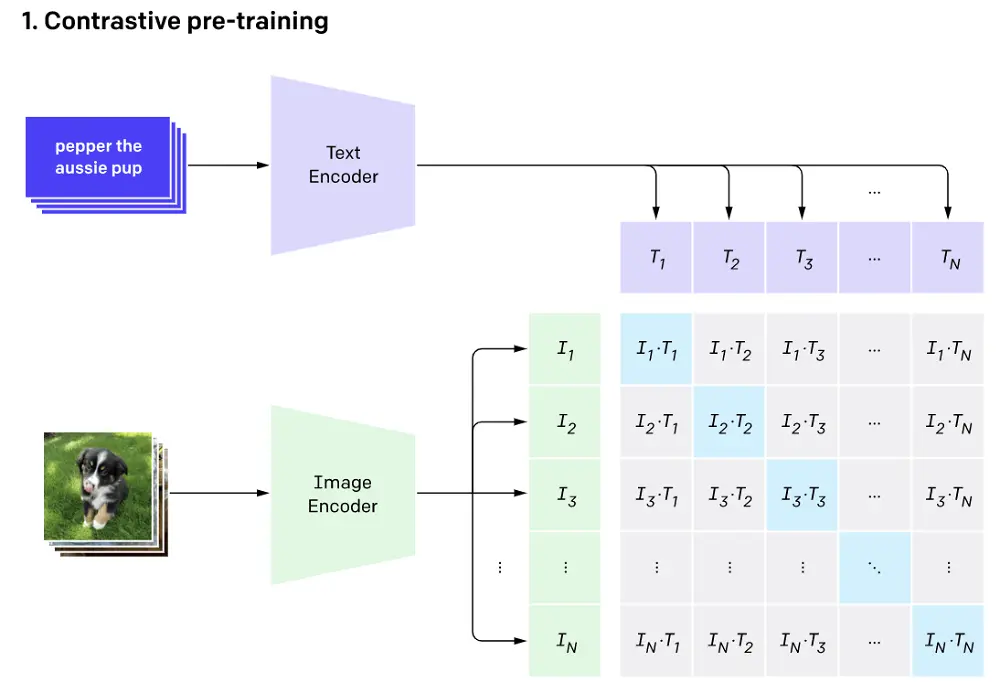

### Step 1: Caclulate Image Embeddings for Dataset

We first want to make our image database easily searchable. To achieve this, we calculate the image embedding for each image using the image encoder. **This has already been done for you,** because it is computationally intensive. Below is the code for reference.

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F
from tqdm import tqdm
import numpy

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "ViT-B/32"
pretrained = "openai"
batch_size = 128
image_folder = "/Users/anajuliabortolossi/cs506/CS506_Assignment_10/coco_images_resized"  # Replace with your folder path

# Load the model and preprocess function
model, preprocess_train, preprocess_val = create_model_and_transforms(model_name, pretrained=pretrained)
model = model.to(device)
model.eval()

# Image transformations (using preprocess_val from open_clip)
transform = preprocess_val

# Collect all image paths
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
print('Number of images:', len(image_paths))
# DataFrame to store results
results = []

# Function to load and preprocess images
def load_images(batch_paths):
    images = []
    for path in batch_paths:
        try:
            image = Image.open(path).convert("RGB")
            images.append(transform(image))
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            ## continue
    return torch.stack(images) if images else None

# Process images in batches
with torch.no_grad():
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing images"):
        batch_paths = image_paths[i:i + batch_size]
        images = load_images(batch_paths)
        if images is None:  # Skip if no valid images in this batch
            continue

        images = images.to(device)
        embeddings = model.encode_image(images)
        embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize the embeddings

        for path, emb in zip(batch_paths, embeddings):
            results.append({"file_name": os.path.basename(path), "embedding": emb.cpu().numpy()})

import pandas as pd
# Save results to a DataFrame
df = pd.DataFrame(results)
df.to_pickle('image_embeddings.pickle')

Run the code below to examine the dataframe.

The dataframe `df` has two columns. The first column is the image file in the dataset folder. The second column is the image embedding corresponding to that image.

In [ ]:
import pandas as pd
df = pd.read_pickle('image_embeddings.pickle')
df

### Step 2: Image-to-Image Search

Now you will write some code to find the closest image in the dataset to a given image query.

Find a random image off the internet. Use the CLIP image encoder to encode the image; let's call this the `query_embedding`.

Now, display the image in the dataset that has the **maximum cosine similarity with the query embedding.**

**It is very important that you use the `ViT-B/32, openai` version of the CLIP model** to be consistent with the embeddings you were given.

Here's the documentation for CLIP: https://github.com/mlfoundations/open_clip

**Hint:** Take advantage of the code given to you at the bedginning of this assignment.

In [ ]:
! pip install open-clip-torch

In [ ]:
from IPython.display import Image
print('This is my query image')
Image(filename="house.jpg")

In [ ]:
from PIL import Image
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F

model, _, preprocess = create_model_and_transforms('ViT-B/32', pretrained='openai')

# This converts the image to a tensor
image = preprocess(Image.open("house.jpg")).unsqueeze(0)

# This calculates the query embedding
query_embedding = F.normalize(model.encode_image(image))

In [ ]:
# Retrieve the image path that corresponds to the embedding in `df`
# with the highest cosine similarity to query_embedding
# Load the query image
query_image_path = "house.jpg"  # Replace with your query image path
query_image = preprocess(Image.open(query_image_path)).unsqueeze(0).to(device)

# Compute the query embedding
with torch.no_grad():
    query_embedding = F.normalize(model.encode_image(query_image), p=2, dim=1)

# Function to calculate cosine similarity
def cosine_similarity(embedding1, embedding2):
    return torch.dot(embedding1.squeeze(), embedding2.squeeze())

# Find the image in the dataset with the highest cosine similarity to the query embedding
max_similarity = float('-inf')
best_match_path = None

for _, row in df.iterrows():
    embedding = torch.tensor(row['embedding'], device=device)
    similarity = cosine_similarity(query_embedding, embedding)
    if similarity > max_similarity:
        max_similarity = similarity
        best_match_path = row['file_name']

# Display the query image
print("Query Image:")
DisplayImage(filename=query_image_path).show()

# Display the best match image
print("Most Similar Image in Dataset:")
DisplayImage(filename=best_match_path).show()

In [ ]:
from IPython.display import Image
Image(filename=impath)

### Step 3: Text-to-Image Search

Now implement text-to-image-search.

The only difference here is that the query is a string of text. You will use the text encoder to obtain the corresponding query embedding.

In [ ]:
import open_clip

tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.eval()
text = tokenizer(["cat cuddles with dog on sofa."])
query_embedding = F.normalize(model.encode_text(text))

# Retrieve the image path that corresponds to the embedding in `df`
# with the highest cosine similarity to query_embedding
impath =

from IPython.display import Image
Image(filename=impath)

### Step 4:  Hybrid Query

A more interesting query could contain both image and text.

For example, instead of explicitly searching for an "image of snowy house", you could search for "snowy" + an image of a house.


In this case, you should embed both the text query and the image query. Then, the query embedding is a weighted average of the two embeddings.

In [ ]:
from PIL import Image

image = preprocess(Image.open("house.jpg")).unsqueeze(0)
image_query = F.normalize(model.encode_image(image))
text = tokenizer(["snowy"])
text_query = F.normalize(model.encode_text(text))

lam  = 0.8 # tune this

query = F.normalize(lam * text_query + (1.0 - lam) * image_query)

impath =

from IPython.display import Image
Image(filename=impath)